In [10]:
%%capture

import sys
sys.path.append('../Documents/GitHub/gauche/')

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from grakel import Graph
from grakel.kernels import WeisfeilerLehmanOptimalAssignment
from rdkit.Chem import MolFromSmiles, FindAtomEnvironmentOfRadiusN, PathToSubmol
import matplotlib.pyplot as plt
from functools import lru_cache

import torch, gpytorch, warnings
from gprotorch import SIGP, Inputs, Kernel

%matplotlib inline
plt.style.use('seaborn-pastel')
warnings.filterwarnings(action='ignore', category=UserWarning, module=r'gpytorch')
warnings.filterwarnings(action='ignore', category=gpytorch.utils.warnings.NumericalWarning, module=r'gpytorch')

ModuleNotFoundError: No module named 'gprotorch'

In [5]:
data = pd.read_csv('data/God file_Oct_24.csv').loc[165:195].reset_index(drop=True) # spasyuk 13
data = data[['Catalyst', 'Ester', 'Yield (%)', 'temp (oC)', 'pressure (bar)']]
data.columns = ['c', 'e', 'y', 't', 'p']
data['idx'] = np.arange(len(data))
data['c'] = data.c.str.replace('[a-zA-Z]', '', regex=True).astype(int)
data['e'] = data.e.str.replace('[a-zA-Z]', '', regex=True).astype(int)

smiles = pd.read_csv('data/db_smiles.csv', header=None)[[0, 1]]
smiles.columns = ['comp', 'smile']
cats = smiles.loc[smiles.comp.str.contains('C')].copy()
cats['comp'] = cats.comp.str.replace('[_a-zA-Z]', '', regex=True).astype(int)
ests = smiles.loc[smiles.comp.str.contains('E')].copy()
ests['comp'] = ests.comp.str.replace('[_a-zA-Z]', '', regex=True).astype(int)
cats = cats.drop_duplicates('comp')
ests = ests.drop_duplicates('comp')

In [6]:
data = data.merge(cats, right_on='comp', left_on='c').drop(['c', 'comp'], axis=1)
data = data.rename(columns=dict(smile='c'))
data = data.merge(ests, right_on='comp', left_on='e').drop(['e', 'comp'], axis=1)
data = data.rename(columns=dict(smile='e'))
data = data.reset_index(drop=True)

In [6]:
!pip install xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [7]:
data['c'] = data.c.str.replace('[N]', '[N+]', regex=False)
data['c'] = data.c.str.replace('[NH]', '[NH+]', regex=False)
data['c'] = data.c.str.replace('[NH1]', '[NH1+]', regex=False)
data['c'] = data.c.str.replace('[NH2]', '[NH2+]', regex=False)
data['c'] = data.c.str.replace('[N@@H]', '[N@@H+]', regex=False)
data['c'] = data.c.str.replace('[N@H]', '[N@H+]', regex=False)
data['c'] = data.c.str.replace('[N@@]', '[N@@+]', regex=False)
data['c'] = data.c.str.replace('[BH4]', '[BH4-]', regex=False)
data['c'] = data.c.str.replace('[B]', '[B-]', regex=False)

In [9]:
from gprotorch import SIGP, Inputs, Kernel
softplus = torch.nn.Softplus()
class GraphGP(SIGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.intercept = gpytorch.means.ConstantMean()
        self.covariance_smt = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=2))
        self.covariance_cat = GraphKernel(kernel)
        self.covariance_est = GraphKernel(kernel)
        self.powers = torch.nn.Parameter(torch.tensor([0.5, 0.5]))

    def forward(self, x):
        temp_pres = torch.cat([p[2][None, :] for p in x.data], axis=0)
        mean = self.intercept(torch.zeros(len(x.data), 1)).float()
        covariance = self.covariance_cat(x, 'catalyst').pow(softplus(self.powers[0])) + \
                     self.covariance_est(x, 'ester').pow(softplus(self.powers[1])) + \
                     self.covariance_smt(temp_pres)
        jitter = max(covariance.diag().mean().detach().item()*1e-4, 1e-4)
        covariance += torch.eye(len(x.data))*jitter
        return gpytorch.distributions.MultivariateNormal(mean, covariance)

class GraphKernel(Kernel):
    def __init__(self, graph_kernel, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.kernel = graph_kernel

    @lru_cache(maxsize=10)
    def kern(self, X, which):
        X = [graphs[0 if which=='catalyst' else 1] for graphs in X.data]
        return torch.tensor(self.kernel.fit_transform(X)).float()

    def forward(self, X, w):
        return self.scale(self.kern(X, w))

ModuleNotFoundError: No module named 'gprotorch'

In [6]:
n_trials = 20
test_set_size = 0.25

In [7]:
bond_types = {1.0: 'S', 1.5: 'A', 2.0: 'D', 3.0: 'O'}

def to_graph(mol):
    ''' from leo's branch, modified '''
    node_labels = {i: mol.GetAtomWithIdx(i).GetSymbol() for i in range(mol.GetNumAtoms())}
    edges = {}
    for bond in mol.GetBonds():
        start_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        bond_type = bond.GetBondTypeAsDouble()

        edges[(start_idx, end_idx)] = bond_types[bond_type]
        edges[(end_idx, start_idx)] = bond_types[bond_type]
    edge_list = list(edges.keys())

    if len(edge_list) == 0:
        print('empty graph')
        edge_list = [(0, 0)]
    graph = Graph(edge_list,
        node_labels=node_labels,
        edge_labels=edges)
    return graph

def to_graph_catalyst(mol):
    node_labels = {i: mol.GetAtomWithIdx(i).GetSymbol() for i in range(mol.GetNumAtoms())}
    ru_n = int(np.where(np.array(list(node_labels.values())) == 'Ru')[0][0])
    env = FindAtomEnvironmentOfRadiusN(mol, 3, ru_n)
    mol = PathToSubmol(mol, env, atomMap={})
    return to_graph(mol)

The training/evaluation loop

In [8]:
kernel = WeisfeilerLehmanOptimalAssignment(n_iter=20)

X = [(
    to_graph(MolFromSmiles(data.loc[i, 'c'])), \
    to_graph(MolFromSmiles(data.loc[i, 'e'])),
    torch.tensor(data.loc[i, ['t', 'p']]).float()
) for i in range(len(data))]
y = np.array(data.y, dtype='float')

r2_list = []; rmse_list = []; pred_dicts = []
for i in range(0, n_trials):
    np.random.seed(i); torch.manual_seed(i)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_set_size, random_state=i)
    
    y_train = torch.tensor(y_train).flatten().float()
    y_test = torch.tensor(y_test).flatten().float()

    X_train = Inputs(X_train); X_test = Inputs(X_test)

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GraphGP(X_train, y_train, likelihood, kernel)

    model.train(); likelihood.train()

    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    for j in range(200):
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval(); likelihood.eval()

    f_pred = model(X_test)
    y_pred = f_pred.mean

    y_pred = y_pred.detach().unsqueeze(dim=1)
    y_test = y_test.detach().unsqueeze(dim=1)

    score = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    r2_list.append(score)
    rmse_list.append(rmse)
    
    f_train = model(X_train).loc.detach()
    
    pred_dicts.append(dict(
        y_train=y_train.numpy().reshape(-1),
        y_train_pred=f_train.numpy().reshape(-1),
        y_test=y_test.numpy().reshape(-1),
        y_test_pred=y_pred.numpy().reshape(-1)
    ))

r2_list = np.array(r2_list)
rmse_list = np.array(rmse_list)
print(f"R^2s: {np.mean(r2_list)} +- {np.std(r2_list)}")
print(f"RMSEs: {np.mean(rmse_list)} +- {np.std(rmse_list)}")
# test R2

R^2s: 0.5656785965893445 +- 0.5731591285036732
RMSEs: 13.29859447479248 +- 5.528521537780762


In [9]:
# training R2
f_train = model(X_train).loc.detach()
r2_score(y_train, f_train)

0.9719598887859167

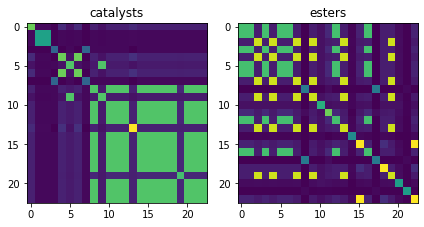

In [10]:
# catalyst and ester covariance
idx = y_train.sort().indices
covar_catalysts = model.covariance_cat(X_train, 'catalyst').detach()
covar_esters = model.covariance_est(X_train, 'ester').detach()
fig, (ax_a, ax_b) = plt.subplots(1, 2)
ax_a.imshow(covar_catalysts[idx, :][:, idx])
ax_a.set_title('catalysts')
ax_b.imshow(covar_esters[idx, :][:, idx])
ax_b.set_title('esters')
plt.tight_layout()

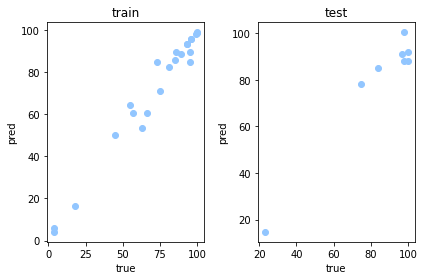

In [11]:
# pred, true scatterplots
fig, (ax_a, ax_b) = plt.subplots(1, 2)
ax_a.scatter(y_train, f_train)
ax_a.set_title('train')
ax_a.set_xlabel('true')
ax_a.set_ylabel('pred')
ax_b.scatter(y_test, y_pred)
ax_b.set_title('test')
ax_b.set_xlabel('true')
ax_b.set_ylabel('pred')
plt.tight_layout()

Text(0.5, 1.0, 'histogram of yields')

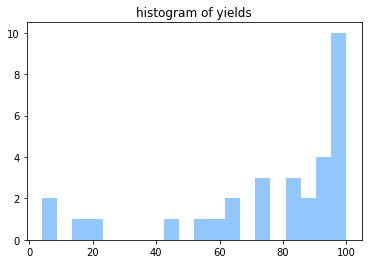

In [12]:
plt.hist(y, bins=20)
plt.title('histogram of yields')

In [13]:
import pickle as pkl
from pprint import pprint
pprint(pred_dicts)
with open('ys.pkl', 'wb') as file:
    pkl.dump(pred_dicts, file)

[{'y_test': array([  4.,  93.,  98.,  55., 100., 100.,  73.,  23.], dtype=float32),
  'y_test_pred': array([ 39.007584,  99.117355, 105.6281  ,  78.245285,  99.11833 ,
        95.49724 ,  93.48308 ,  54.337875], dtype=float32),
  'y_train': array([ 85.,  81.,  95.,  66.,  45.,  96.,  98., 100.,  63.,  99.,  84.,
        86.,  96., 100.,  93.,  18.,  57.,  97.,  75.,   4.,  95.,  75.,
        89.], dtype=float32),
  'y_train_pred': array([86.08159  , 86.92119  , 90.29765  , 63.06157  , 47.731308 ,
       97.58537  , 93.84294  , 99.92705  , 62.915024 , 99.03691  ,
       82.25499  , 90.29765  , 96.239914 , 99.06352  , 93.00554  ,
       18.704424 , 58.290543 , 96.624435 , 74.28816  ,  3.3741322,
       93.48308  , 73.620865 , 89.618454 ], dtype=float32)},
 {'y_test': array([100.,  75.,  93.,  81.,  73.,  95., 100.,  96.], dtype=float32),
  'y_test_pred': array([95.21352 , 77.460686, 94.711685, 97.578995, 94.91054 , 94.91054 ,
       94.71364 , 95.04469 ], dtype=float32),
  'y_train': arr